In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
df_restaurantes = pd.read_parquet('Datawarehouse/restaurantes.parquet')
# df_estados = pd.read_parquet('Datawarehouse/estados.parquet')
# df_reseñas = pd.read_parquet('Datawarehouse/reviewstexto.parquet')

# Wordcloud

In [4]:
df_reseñas.info()
df_reseñas.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2216614 entries, 14 to 12337579
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   id_usuario              object 
 1   id_restaurante          object 
 2   id_resena               object 
 3   calificacion            int64  
 4   anio                    int32  
 5   texto                   object 
 6   puntaje_de_sentimiento  float64
dtypes: float64(1), int32(1), int64(1), object(4)
memory usage: 126.8+ MB


,id_usuario,id_restaurante,id_resena,calificacion,anio,texto,puntaje_de_sentimiento
14,GtqEcbHF-WTfKlms9250ZQ,7wQEzj-0yOpLiANNLuUflQ,nAE4IGJMRxDfas0qYabMWw,4,2016,Excellent service! Great diner food and breakf...,7.8
16,Z5j9Xw_G0c7M2b1-iS67wg,HTqXI5S2XcSlh_ylx9sE6g,4KpIldEM-tdnrJLqYzRfZQ,5,2018,I've only had the cannolis here but they are a...,7.3
17,UsBxLh14sUpO8SdeqIiGOA,Wy8Hswf2cLQGRZN6armkag,PDHRlnEdkEcwATry4w71PQ,1,2011,"If I could give it a zero, I would. I order a ...",4.6
22,EfG0nInFMbiO9Hy7A6B2cQ,fGYnHzFr1z2kv7bPRW6VMA,jSoo6p_GpvYRHG2QK6WE2g,3,2017,Sometimes this food is very very good. Unfort...,7.1
25,JriXL8qqw_tJ1mpwtlBabg,1QVB0_-piu0GXes87BXeGw,OJO7m2zn3LAr011J1I7ppQ,5,2017,Love this place...best hot dogs and chili dogs...,7.1


In [11]:
df_reseñas_negativas = df_reseñas[df_reseñas['puntaje_de_sentimiento'] < 5]
df_reseñas_negativas_text = " ".join(df_reseñas_negativas['texto'].tolist()).lower()

id_usuario                152590
id_restaurante            152590
id_resena                 152590
calificacion              152590
anio                      152590
texto                     152590
puntaje_de_sentimiento    152590
dtype: int64

In [12]:
wordcloud_neg = WordCloud(stopwords = STOPWORDS,
                      collocations=True, background_color='white').generate(df_reseñas_negativas_text)

cuenta_palabras_neg = pd.DataFrame(data=[wordcloud_neg.process_text(df_reseñas_negativas_text)]).T.rename({0:'count'}, axis=1).sort_values(by='count',ascending=False) 

In [22]:
cuenta_palabras_neg.head(15)

,count
food,38827
order,27869
place,25119
ordered,16316
one,16171
got,13606
time,12493
good,11360
go,11334
cold,10934


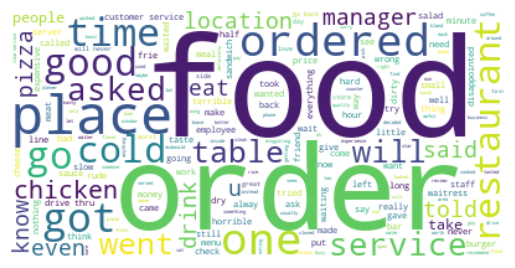

In [14]:
plt.imshow(wordcloud_neg, interpolation='bilInear')
plt.axis('off')
plt.show()

In [16]:
df_reseñas_positivas = df_reseñas[df_reseñas['puntaje_de_sentimiento'] > 7]
df_reseñas_positivas_text = " ".join(df_reseñas_positivas['texto'].tolist()).lower()

id_usuario                613578
id_restaurante            613578
id_resena                 613578
calificacion              613578
anio                      613578
texto                     613578
puntaje_de_sentimiento    613578
dtype: int64

In [17]:
wordcloud_pos = WordCloud(stopwords = STOPWORDS,
                      collocations=True, background_color='white').generate(df_reseñas_positivas_text)

cuenta_palabras_pos = pd.DataFrame(data=[wordcloud_pos.process_text(df_reseñas_positivas_text)]).T.rename({0:'count'}, axis=1).sort_values(by='count',ascending=False) 

In [23]:
cuenta_palabras_pos.head(15)

,count
great food,52111
good food,48342
love,38551
place,38114
great service,30565
deliciou,25745
food great,20240
amazing,19031
one,18766
good service,18159


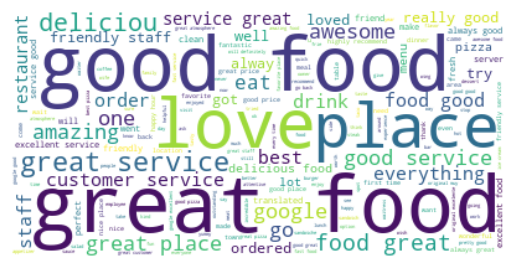

In [25]:
plt.imshow(wordcloud_pos, interpolation='bilInear')
plt.axis('off')
plt.show()

# modelo no supervisado - clustering (explorar restaurantes)

In [3]:
df_restaurantes = df_restaurantes[df_restaurantes['nombre'] == 'Subway']
df_restaurantes.head()

,id_restaurante,id_estado,nombre,categorias,cantidad_resenas,latitud,longitud,atributos,calificacion
1649,gi90NMmRhzl8vzM83UNOVA,9.0,Subway,"Food, Sandwiches, Restaurants, Fast Food",14,28.150110,-82.353997,"{'AcceptsInsurance': None, 'Accessibility': No...",3.0
3209,wXBAAafoiZ4Nty2ajuBtfw,14.0,Subway,"Restaurants, Sandwiches, Fast Food",11,39.884360,-86.067905,"{'AcceptsInsurance': None, 'Accessibility': No...",2.5
3262,pFtvNuoUppn9GYx0_ZsW5w,14.0,Subway,"Sandwiches, Restaurants, Fast Food",6,39.910207,-86.183382,"{'AcceptsInsurance': None, 'Accessibility': No...",2.5
3724,CmDTNEVReN6CgE6ctlZhag,14.0,Subway,"Sandwiches, Salad, Fast Food, Restaurants",7,39.676701,-86.309883,"{'AcceptsInsurance': None, 'Accessibility': No...",3.0
4609,31s1x27DnN2V-ptUWEdfTQ,14.0,Subway,"Sandwiches, Restaurants, Fast Food",7,39.912251,-86.261775,"{'AcceptsInsurance': None, 'Accessibility': No...",3.5


In [4]:
# Definir la función de categorización
def categorize_rating(rating):
    if 0 <= rating <= 4:
        return 0
    elif 4 < rating <= 5:
        return 1
    else:
        return None  # En caso de que el valor esté fuera del rango esperado

# Aplicar la función a la columna de calificaciones
df_restaurantes['calificacion'] = df_restaurantes['calificacion'].apply(categorize_rating)

In [5]:
df_restaurantes = pd.concat([df_restaurantes.query('calificacion == 0').sample(2481), df_restaurantes[df_restaurantes['calificacion'] == 1]])

In [6]:
df_restaurantes['calificacion'].value_counts()

calificacion
0    2481
1    2481
Name: count, dtype: int64

In [7]:
df_res_atributos = pd.json_normalize(df_restaurantes['atributos'])
df_res_atributos = pd.concat([df_restaurantes['calificacion'], df_res_atributos])

In [8]:
# Calcular la cantidad de valores nulos por columna
valores_nulos = df_res_atributos.isnull().sum()

# Obtener las columnas que tienen 8537 valores nulos
valores_nulos = valores_nulos[valores_nulos >= 7683].index

# Eliminar las columnas con la cantidad específica de valores nulos
df_res_atributos = df_res_atributos.drop(columns=valores_nulos)

In [9]:
df_res_atributos = df_res_atributos.fillna(False)

In [10]:
df_res_atributos.info()
df_res_atributos.head()

<class 'pandas.core.frame.DataFrame'>
Index: 9924 entries, 183032 to 4961
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   calificacion     9924 non-null   object
 1   Accessibility    9924 non-null   object
 2   Amenities        9924 non-null   object
 3   Atmosphere       9924 non-null   object
 4   Crowd            9924 non-null   object
 5   Dining options   9924 non-null   object
 6   Offerings        9924 non-null   object
 7   Payments         9924 non-null   object
 8   Popular for      9924 non-null   object
 9   Service options  9924 non-null   object
dtypes: object(10)
memory usage: 852.8+ KB


,calificacion,Accessibility,Amenities,Atmosphere,Crowd,Dining options,Offerings,Payments,Popular for,Service options
183032,0.0,False,False,False,False,False,False,False,False,False
93540,0.0,False,False,False,False,False,False,False,False,False
135057,0.0,False,False,False,False,False,False,False,False,False
133526,0.0,False,False,False,False,False,False,False,False,False
50407,0.0,False,False,False,False,False,False,False,False,False


In [11]:
# Función para convertir los arrays en listas de cadenas
def convertir_a_lista(array):
    return [str(elemento) for elemento in array]

# Define una función para contar el número de elementos en una lista
def contar_elementos(lista):
    # Verifica si la entrada es una lista
    if isinstance(lista, list):
        # Si la lista contiene solo el valor 'False', retorna 0
        if len(lista) == 1 and lista[0] == 'F':
            return 0
        # Retorna la longitud de la lista
        return len(lista)
    else:
        # Si no es una lista, retorna 0
        return 0

In [32]:
# df_res_atributos['Accessibility'] = df_res_atributos['Accessibility'].apply(convertir_a_lista)
# df_res_atributos['Accessibility'] = df_res_atributos['Accessibility'].apply(contar_elementos)

In [33]:
# df_res_atributos['Accessibility'].value_counts()

In [ ]:
var_dum = pd.get_dummies(df_res_atributos['Accessibility'].apply(pd.Series).stack())

In [21]:
# Convertir la columna 'Crowd' en variables dummy
var_dum = pd.get_dummies(df_res_atributos['Accessibility'].apply(pd.Series).stack())

# Mostrar las ocurrencias de cada variable dummy
var_dum.drop(columns=False , inplace= True)

# Concatenar las variables dummy al DataFrame original
# var_dum = var_dum.reset_index().groupby('level_0').sum().drop(columns='level_1')
# df_res_atributos = pd.concat([df_res_atributos, var_dum], axis=1)
var_dum

Wheelchair accessible elevator  Wheelchair accessible entrance  \
183032 0                           False                           False   
93540  0                           False                           False   
135057 0                           False                           False   
133526 0                           False                           False   
50407  0                           False                           False   
...                                  ...                             ...   
4960   1                           False                           False   
       2                           False                           False   
4961   0                           False                            True   
       1                           False                           False   
       2                           False                           False   

          Wheelchair accessible parking lot  Wheelchair accessible restroom  \
183032 0                              False                           False   
93540  0                              False                           False   
135057 0                              False                           False   
133526 0                              False                           False   
50407  0                              False                           False   
...                                     ...                             ...   
4960   1                               True                           False   
       2                              False                           False   
4961   0                              False                           False   
       1                               True                           False   
       2                              False                            True   

          Wheelchair accessible seating  Wheelchair-accessible car park  \
183032 0                          False                           False   
93540  0                          False                           False   
135057 0                          False                           False   
133526 0                          False                           False   
50407  0                          False                           False   
...                                 ...                             ...   
4960   1                          False                           False   
       2                           True                           False   
4961   0                          False                           False   
       1                          False                           False   
       2                          False                           False   

          Wheelchair-accessible entrance  Wheelchair-accessible lift  \
183032 0                           False                       False   
93540  0                           False                       False   
135057 0                           False                       False   
133526 0                           False                       False   
50407  0                           False                       False   
...                                  ...                         ...   
4960   1                           False                       False   
       2                           False                       False   
4961   0                           False                       False   
       1                           False                       False   
       2                           False                       False   

          Wheelchair-accessible seating  Wheelchair-accessible toilet  
183032 0                          False                         False  
93540  0                          False                         False  
135057 0                          False                         False  
133526 0                          False                         False  
50407  0              

In [ ]:
# df_res_atributos['Amenities'].value_counts()

In [ ]:
# Convertir la columna 'Crowd' en variables dummy
var_dum = pd.get_dummies(df_res_atributos['Amenities'].apply(pd.Series).stack())

# Mostrar las ocurrencias de cada variable dummy
var_dum.drop(columns=False , inplace= True)

# Concatenar las variables dummy al DataFrame original
var_dum = var_dum.reset_index().groupby('level_0').sum().drop(columns='level_1')
df_res_atributos = pd.concat([df_res_atributos, var_dum], axis=1)
var_dum

,Gender-neutral restroom,Gender-neutral toilets,Good for kids,High chairs,Restroom,Toilets,Wi-Fi
level_0,,,,,,,
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
8532,0,0,1,0,0,0,0
8533,0,0,1,0,0,0,0
8534,0,0,1,0,0,0,0


In [ ]:
# df_res_atributos['Atmosphere'].value_counts()

In [ ]:
# Convertir la columna 'Crowd' en variables dummy
var_dum = pd.get_dummies(df_res_atributos['Atmosphere'].apply(pd.Series).stack())

# Mostrar las ocurrencias de cada variable dummy
var_dum.drop(columns=False , inplace= True)

# Concatenar las variables dummy al DataFrame original
var_dum = var_dum.reset_index().groupby('level_0').sum().drop(columns='level_1')
df_res_atributos = pd.concat([df_res_atributos, var_dum], axis=1)
var_dum


,Casual,Cozy,Trending
level_0,,,
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
8532,1,0,0
8533,1,0,0
8534,1,0,0


In [ ]:
# df_res_atributos['Crowd'].value_counts()

In [ ]:
# Convertir la columna 'Crowd' en variables dummy
var_dum = pd.get_dummies(df_res_atributos['Crowd'].apply(pd.Series).stack())

# Mostrar las ocurrencias de cada variable dummy
var_dum.drop(columns=False , inplace= True)

# Concatenar las variables dummy al DataFrame original
var_dum = var_dum.reset_index().groupby('level_0').sum().drop(columns='level_1')
df_res_atributos = pd.concat([df_res_atributos, var_dum], axis=1)
var_dum

,College students,Family friendly,Family-friendly,Groups,Tourists,University students
level_0,,,,,,
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
8532,0,0,0,0,1,0
8533,0,0,0,1,1,0
8534,0,0,0,1,1,0


In [ ]:
# df_res_atributos['Dining options'].value_counts()

In [ ]:
# Convertir la columna 'Crowd' en variables dummy
var_dum = pd.get_dummies(df_res_atributos['Dining options'].apply(pd.Series).stack())

# Mostrar las ocurrencias de cada variable dummy
var_dum.drop(columns=False , inplace= True)

# Concatenar las variables dummy al DataFrame original
var_dum = var_dum.reset_index().groupby('level_0').sum().drop(columns='level_1')
df_res_atributos = pd.concat([df_res_atributos, var_dum], axis=1)
var_dum

,Breakfast,Catering,Dessert,Dinner,Lunch,Seating
level_0,,,,,,
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
8532,0,0,0,0,1,0
8533,0,1,1,0,1,0
8534,0,1,1,0,1,0


In [ ]:
# df_res_atributos['Health & safety'].value_counts()

In [ ]:
# Convertir la columna 'Crowd' en variables dummy
var_dum = pd.get_dummies(df_res_atributos['Health & safety'].apply(pd.Series).stack())

# Mostrar las ocurrencias de cada variable dummy
var_dum.drop(columns=False , inplace= True)

# Concatenar las variables dummy al DataFrame original
var_dum = var_dum.reset_index().groupby('level_0').sum().drop(columns='level_1')
df_res_atributos = pd.concat([df_res_atributos, var_dum], axis=1)
var_dum

,Mask required,Staff get temperature checks,Staff required to disinfect surfaces between visits,Staff wear masks,Temperature check required
level_0,,,,,
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
8532,1,0,0,0,0
8533,0,0,0,0,0
8534,1,0,0,0,0


In [ ]:
# df_res_atributos['Highlights'].value_counts()

In [ ]:
# Convertir la columna 'Crowd' en variables dummy
var_dum = pd.get_dummies(df_res_atributos['Highlights'].apply(pd.Series).stack())

# Mostrar las ocurrencias de cada variable dummy
var_dum.drop(columns=False , inplace= True)

# Concatenar las variables dummy al DataFrame original
var_dum = var_dum.reset_index().groupby('level_0').sum().drop(columns='level_1')
df_res_atributos = pd.concat([df_res_atributos, var_dum], axis=1)
var_dum

,Active military discounts,Fast service,Fireplace,Great tea selection,LGBTQ friendly,Sports,Transgender safespace
level_0,,,,,,,
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
8532,0,0,0,0,0,0,0
8533,0,0,0,0,0,0,0
8534,0,0,0,0,0,0,0


In [ ]:
# df_res_atributos['Offerings'].value_counts()

In [ ]:
# Convertir la columna 'Crowd' en variables dummy
var_dum = pd.get_dummies(df_res_atributos['Offerings'].apply(pd.Series).stack())

# Mostrar las ocurrencias de cada variable dummy
var_dum.drop(columns=False , inplace= True)

# Concatenar las variables dummy al DataFrame original
var_dum = var_dum.reset_index().groupby('level_0').sum().drop(columns='level_1')
df_res_atributos = pd.concat([df_res_atributos, var_dum], axis=1)
var_dum

,Alcohol,Beer,Coffee,Comfort food,Healthy options,Kids' menu,Late-night food,Organic dishes,Quick bite,Salad bar,Small plates,Vegetarian options
level_0,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
8532,0,0,0,1,1,1,0,0,1,0,0,1
8533,0,0,0,0,1,1,0,0,1,0,0,1
8534,0,0,0,1,1,1,0,0,1,0,0,1


In [ ]:
# df_res_atributos['Payments'].value_counts()

In [ ]:
# Convertir la columna 'Crowd' en variables dummy
var_dum = pd.get_dummies(df_res_atributos['Payments'].apply(pd.Series).stack())

# Mostrar las ocurrencias de cada variable dummy
var_dum.drop(columns=False , inplace= True)

# Concatenar las variables dummy al DataFrame original
var_dum = var_dum.reset_index().groupby('level_0').sum().drop(columns='level_1')
df_res_atributos = pd.concat([df_res_atributos, var_dum], axis=1)
var_dum

,Checks,Credit cards,Debit cards,NFC mobile payments
level_0,,,,
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
8532,0,0,1,1
8533,0,0,1,0
8534,0,0,1,0


In [ ]:
# df_res_atributos['Popular for'].value_counts()

In [ ]:
# Convertir la columna 'Crowd' en variables dummy
var_dum = pd.get_dummies(df_res_atributos['Popular for'].apply(pd.Series).stack())

# Mostrar las ocurrencias de cada variable dummy
var_dum.drop(columns=False , inplace= True)

# Concatenar las variables dummy al DataFrame original
var_dum = var_dum.reset_index().groupby('level_0').sum().drop(columns='level_1')
df_res_atributos = pd.concat([df_res_atributos, var_dum], axis=1)
var_dum

,Breakfast,Dinner,Lunch,Solo dining
level_0,,,,
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
8532,0,1,1,1
8533,0,1,1,1
8534,0,1,1,1


In [ ]:
# df_res_atributos['Service options'].value_counts()

In [ ]:
# Convertir la columna 'Crowd' en variables dummy
var_dum = pd.get_dummies(df_res_atributos['Service options'].apply(pd.Series).stack())

# Mostrar las ocurrencias de cada variable dummy
var_dum.drop(columns=False , inplace= True)

# Concatenar las variables dummy al DataFrame original
var_dum = var_dum.reset_index().groupby('level_0').sum().drop(columns='level_1')
df_res_atributos = pd.concat([df_res_atributos, var_dum], axis=1)
var_dum

,Curbside pickup,Delivery,Dine-in,Drive-through,No-contact delivery,Outdoor seating,Takeaway,Takeout
level_0,,,,,,,,
0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
8532,0,1,1,0,0,0,0,1
8533,1,1,1,0,0,0,0,1
8534,0,1,1,0,0,0,0,1


In [ ]:
# Lista de columnas que deseas eliminar
columnas_a_eliminar = ["Accessibility", "Amenities", "Atmosphere", "Crowd", "Dining options", "Health & safety",
                       "Highlights", "Offerings", "Payments", "Popular for", "Service options"]

# Eliminar las columnas del DataFrame
df_res_atributos = df_res_atributos.drop(columnas_a_eliminar, axis=1)

In [ ]:
# Crear el modelo de clustering
n_clusters = 6  # Número de clústeres que deseas obtener
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Ajustar el modelo a tus datos (sin tener en cuenta el índice)
kmeans.fit(df_res_atributos)

# Obtener las etiquetas de los clústeres para cada fila
etiquetas = kmeans.labels_

# Mostrar las etiquetas de los clústeres
print(etiquetas)

[4 4 4 ... 2 2 0]


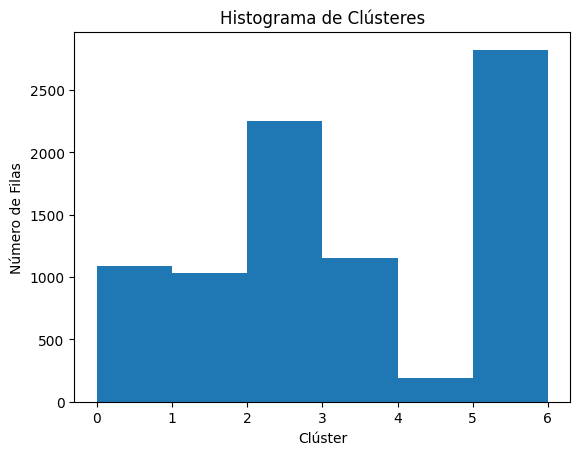

In [ ]:
# Plot histograma de las etiquetas de los clústeres
plt.hist(etiquetas, bins=range(n_clusters + 1))
plt.xlabel('Clúster')
plt.ylabel('Número de Filas')
plt.title('Histograma de Clústeres')
plt.show()

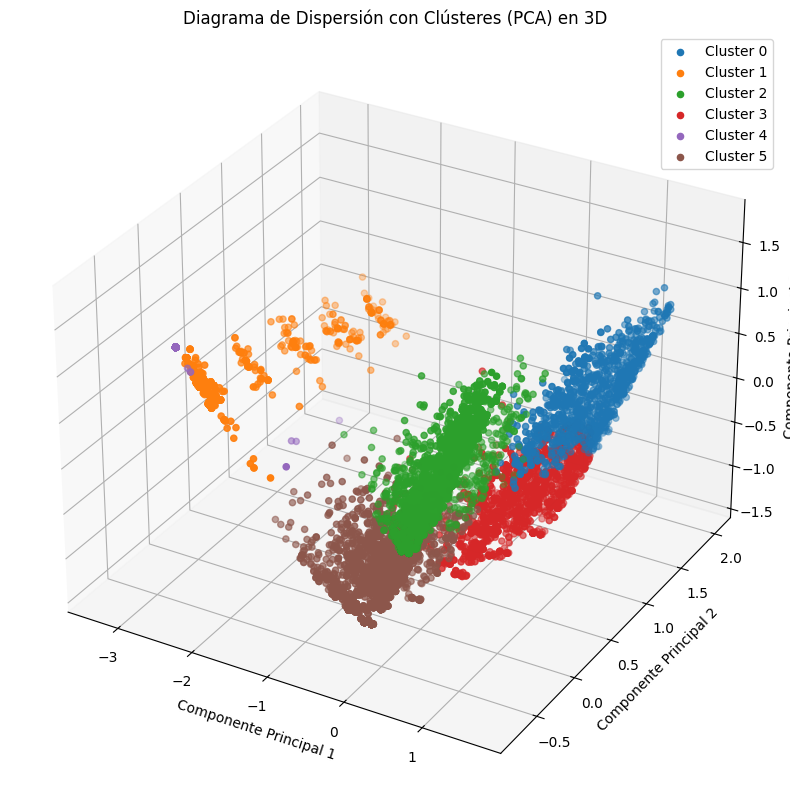

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Realizar la reducción de dimensionalidad utilizando PCA con 3 componentes principales
pca = PCA(n_components=3)
componentes_principales = pca.fit_transform(df_res_atributos)

# Crear un DataFrame con las componentes principales y las etiquetas de los clústeres
df_pca = pd.DataFrame(data=componentes_principales, columns=['Componente 1', 'Componente 2', 'Componente 3'])
df_pca['Cluster'] = etiquetas

# Plot scatter plot en 3D con colores según las etiquetas de clústeres en el espacio reducido por PCA
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
for cluster in range(n_clusters):
    ax.scatter(df_pca.loc[df_pca['Cluster'] == cluster, 'Componente 1'],
               df_pca.loc[df_pca['Cluster'] == cluster, 'Componente 2'],
               df_pca.loc[df_pca['Cluster'] == cluster, 'Componente 3'],
               label=f'Cluster {cluster}')
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Componente Principal 3')
ax.set_title('Diagrama de Dispersión con Clústeres (PCA) en 3D')
ax.legend()
plt.show()

In [ ]:
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)


# modelo supervisado - RF (predicción de rating)